In [20]:
import pandas as pd
import numpy as np

#Importantando planilhas
resgates=pd.read_excel('Resgates e comunicacao.xlsx',sheet_name='Resgates')
email=pd.read_excel('Resgates e comunicacao.xlsx',sheet_name='Emails')
metas=pd.read_csv('Metas .csv', delimiter=';')

In [21]:
#Manipulando planilha de resgates
#Retirando data acima de 2019
resgates=resgates[resgates['Data']<'2020-01-01']
#Renomeando coluna1 para mês
resgates.rename(columns={'Column1':'Mes'},inplace=True)
#Colocando informação de trimestre
resgates['Trimestre']=resgates['Data'].dt.quarter
#Depois de alguma exploração e visualização, percebi um grande outlier na coluna dos pontos
resgates.describe()
#Existe um número máximo muito acima dos outros e um grande desvio padrão
#Retirando Outlier da coluna pontos
rout=resgates['Pontos'][resgates['ID do produto']=='094714157-X'].median()
resgates['Pontos']=resgates['Pontos'].apply(lambda x: rout if x==2900000 else x)

In [22]:
#Manipulando planilha de email
email['Mes']=email['Date'].dt.month
#Convertendo boleana para binário
email[['Email Received','Email Opened','Link Clicked']]=email[['Email Received','Email Opened','Link Clicked']].astype(int)
#Somar colunas binárias e criar nível de engajamento
email['Nivel de engajamento']=email['Email Received']+email['Email Opened']+email['Link Clicked']

In [23]:
#Manipulando planilha de metas
#Arrumando nome de coluna
metas.rename(columns={'Meta ':'Meta'},inplace=True)
#Arrumando tipo de dados da coluna "realizado" para numérico
#Tentei também por métodos convencionais como .replace e astype, porém só funcionou desta forma
def substituir(x):
    '''Função que substitui padrão númerico brasileiro para o internacional (. por ,)'''
    x=x.split(',')
    x='.'.join(x)
    return x
metas['Realizado']=metas['Realizado'].apply(lambda x: substituir(x) if ',' in x else x)
metas['Realizado']=metas['Realizado'].apply(pd.to_numeric)
#Criando colunas para explorar correlações futuramente
metas['Meta_Batida?']=(metas['Realizado'] >= metas['Meta']).astype(int)
metas['PlusDeMeta']=(metas['Realizado'] - metas['Meta'])
metas['PlusDeMeta']=metas['PlusDeMeta'].apply(lambda x: x if x>=0 else 0)

In [24]:
#Criando Query para estudar correlação e diminuindo granularidade das planilhas de resgates e email
def tabela_geral():
    '''Função para juntar data frames sem criar muitas variáveis na memória'''
    #Resultados dos resgates
    r1=resgates.groupby(by=['ID', 'Mes']).count()['ID do produto'].to_frame()
    r1.rename(columns={'ID do produto':'Núm_De_Resgates'},inplace=True)
    r2=resgates.groupby(by=['ID', 'Mes']).sum(numeric_only=True)['Pontos'].to_frame()
    #Agrupando metas 
    m1=metas.set_index(['ID', 'Mes'])
    #Resultado do email
    e1=email.groupby(by=['ID', 'Mes']).sum(numeric_only=True)['Nivel de engajamento'].to_frame()
    e1.rename(columns={'Nivel de engajamento':'Interações mensais (Email)'},inplace=True)

    #A função .join me permite unir a tabelas de maneira fácil somente pelo seu indice
    return r1.join(other=[r2,m1,e1],how='outer')
geral=tabela_geral()
#Criando novas colunas para o estudo de correlação
geral['TeveResgate?']=(geral['Núm_De_Resgates']>0).astype(int)
#Prefiro que ele pelo menos tenha visualizado algum email para contar como interação
geral['Interação_No_Mês?(Email)']=(geral['Interações mensais (Email)']>=2).astype(int)
#Preenchendo os valores vazios que vieram do outer join
geral.fillna(0,inplace=True)
#Estudando correlação entre número de resgates, engajamento e batimento de metas
c1=geral[['Núm_De_Resgates','Meta_Batida?','Interação_No_Mês?(Email)']].corr(method='kendall')
c1=c1.round(decimals = 2).reset_index()
#Não existe correlação entre o número de resgates, engajamento por email e batimento de metas

In [25]:
#Criando imagem da tabela de correlação
import plotly.figure_factory as ff

fig =  ff.create_table(c1)
for i in range(len(fig.layout.annotations)):
    fig.layout.annotations[i].font.size = 8
fig.update_layout(
    autosize=False,
    width=600,
    height=200,
)
fig.write_image("correlação.png", scale=2)
fig.show()

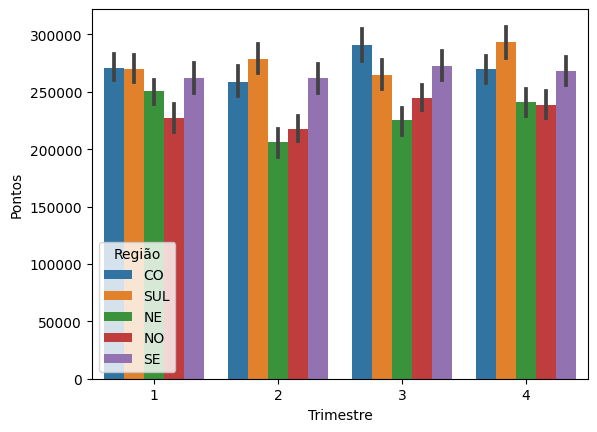

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Plotando resgates de pontos por região em cada trimestre
sns.barplot(x="Trimestre", y="Pontos", hue="Região",estimator=sum, data=resgates)
plt.show()
#Quais regiões tiveram maior a participação no resgate de pontos por trimestre?

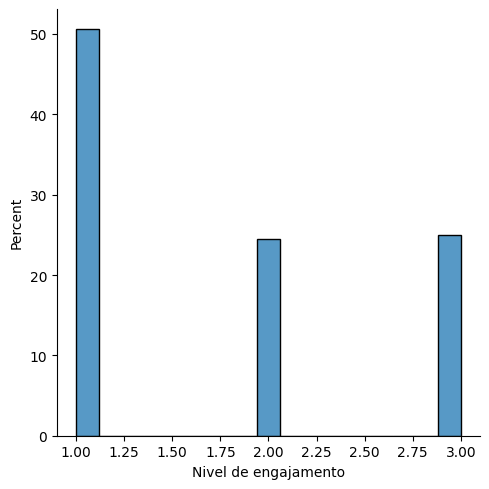

In [27]:
#Quando enviamos um email, qual a porcentagem dos que abrem e/ou clicam no link?
p2= sns.displot(email['Nivel de engajamento'][email['Nivel de engajamento']>0], stat='percent')
plt.show()
#Níveis: 1=Apenas recebeu, 2=Recebeu e visualizou, 3=Abriu o link
#Apenas 25% dos clientes que recebem o email abrem o link

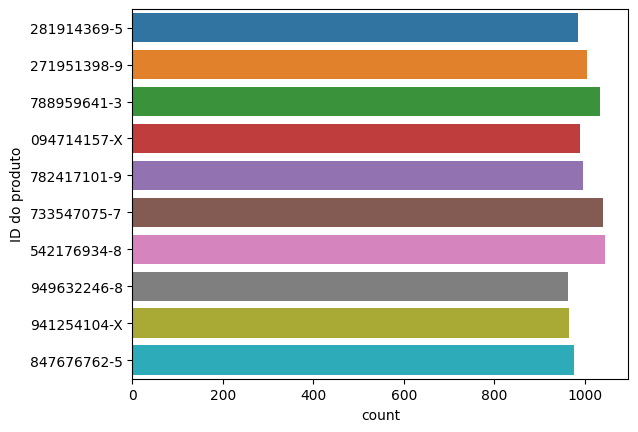

In [28]:
#Plotando resgates de pontos por região em cada trimestre
sns.countplot(y="ID do produto",data=resgates)
plt.show()
#Quais foram os produtos mais resgatados no ano de 2019?